In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from sklearn.datasets import make_moons, make_circles, make_blobs

In [25]:
class HierarchicalClustering:
    def __init__(self, n_clusters=2, linkage='single', distance_metric='euclidean'):
        """
        Initialize the Hierarchical Clustering algorithm.
        
        Parameters:
        -----------
        n_clusters : int, default=2
            The number of clusters to find
        linkage : str, default='single'
            The linkage criterion to use. Can be 'single', 'complete', or 'average'
        distance_metric : str, default='euclidean'
            The distance metric to use. Can be 'euclidean' or 'manhattan'
        """
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.distance_metric = distance_metric
        self.labels_ = None
        self.dendrogram_ = []
    
    def _calculate_distance(self, point1, point2):
        """
        Calculate distance between two points using specified metric.
        """
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((point1 - point2) ** 2))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(point1 - point2))
        else:
            raise ValueError("Unsupported distance metric")
    
    def _compute_distance_matrix(self, X):
        """
        Compute the initial distance matrix between all points from scratch.
        """
        n_samples = X.shape[0]
        distance_matrix = np.zeros((n_samples, n_samples))
        
        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                dist = self._calculate_distance(X[i], X[j])
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist
                
        return distance_matrix
    
    def _get_min_distance(self, distance_matrix):
        """
        Find the two closest clusters in the distance matrix.
        Returns the indices of the clusters and their distance.
        """
        mask = np.triu(np.ones_like(distance_matrix), k=1).astype(bool)
        masked_distances = np.where(mask, distance_matrix, np.inf)
        
        min_distance = np.min(masked_distances)
        min_indices = np.where(distance_matrix == min_distance)
        
        i, j = min_indices[0][0], min_indices[1][0]
        return i, j, min_distance
    
    def _update_distance_matrix(self, distance_matrix, i, j):
        """
        Update the distance matrix after merging clusters i and j.
        """
        if self.linkage == 'single':
            distance_matrix[i] = np.minimum(distance_matrix[i], distance_matrix[j])
            distance_matrix[:, i] = np.minimum(distance_matrix[:, i], distance_matrix[:, j])
        elif self.linkage == 'complete':
            distance_matrix[i] = np.maximum(distance_matrix[i], distance_matrix[j])
            distance_matrix[:, i] = np.maximum(distance_matrix[:, i], distance_matrix[:, j])
        else:  
            distance_matrix[i] = (distance_matrix[i] + distance_matrix[j]) / 2
            distance_matrix[:, i] = (distance_matrix[:, i] + distance_matrix[:, j]) / 2
        
        distance_matrix = np.delete(distance_matrix, j, axis=0)
        distance_matrix = np.delete(distance_matrix, j, axis=1)
        
        return distance_matrix
    
    def fit(self, X):
        """
        Fit the hierarchical clustering model.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data
        """
        n_samples = X.shape[0]
        
        current_clusters = list(range(n_samples))
        self.labels_ = np.arange(n_samples)
        
        distance_matrix = self._compute_distance_matrix(X)
        
        n_clusters = n_samples
        
        while n_clusters > self.n_clusters:
            i, j, dist = self._get_min_distance(distance_matrix)
            
            self.dendrogram_.append({
                'cluster1': current_clusters[i],
                'cluster2': current_clusters[j],
                'distance': dist,
                'size': sum(self.labels_ == current_clusters[i]) + sum(self.labels_ == current_clusters[j])
            })
            
            self.labels_[self.labels_ == current_clusters[j]] = current_clusters[i]
            
            current_clusters.pop(j)
            
            distance_matrix = self._update_distance_matrix(distance_matrix, i, j)
            
            n_clusters -= 1
        
        unique_labels = np.unique(self.labels_)
        for new_label, old_label in enumerate(unique_labels):
            self.labels_[self.labels_ == old_label] = new_label
            
        return self
    
    def fit_predict(self, X):
        """
        Fit the model and return cluster labels.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data
            
        Returns:
        --------
        labels : array of shape (n_samples,)
            Cluster labels
        """
        self.fit(X)
        return self.labels_

In [27]:
def generate_complex_dataset():
    """
    Generate a complex dataset with overlapping clusters of different shapes and densities.
    """
    np.random.seed(42)
    
    X1, _ = make_moons(n_samples=50, noise=0.12)
    X1 = X1 * 3 + np.array([2, 2])
    
    centers = [[1, 1], [3, 2], [2, 3]]
    X2, _ = make_blobs(n_samples=60, centers=centers, cluster_std=[0.7, 0.5, 0.3], random_state=42)
    
    X3, _ = make_circles(n_samples=50, noise=0.08, factor=0.5)
    X3 = X3 * 2 - np.array([3, 0])  
    
    t = np.linspace(0, 1, 30)
    noise = np.random.normal(0, 0.1, (30, 2))
    X4 = np.column_stack([t * 4, np.sin(t * 2 * np.pi) * 0.5]) + noise + np.array([-2, -3])
    
    X5 = np.random.uniform(low=[-4, -6], high=[-2, -4], size=(20, 2))
    
    X = np.vstack([X1, X2, X3, X4, X5])
    
    noise_points = np.random.uniform(low=[-5, -5], high=[5, 5], size=(10, 2))
    X = np.vstack([X, noise_points])
    
    X += np.random.normal(0, 0.1, X.shape)
    
    return X

In [29]:
def plot_clustering_results(X, model, figsize=(20, 15)):
    """
    Create comprehensive visualization of clustering results.
    """
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1.2])
    
    # 1. Original Data
    ax1 = fig.add_subplot(gs[0, 0])
    scatter = ax1.scatter(X[:, 0], X[:, 1], c='lightgray', s=50)
    ax1.set_title('Original Data', fontsize=12, pad=10)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Distance Matrix Heatmap
    ax2 = fig.add_subplot(gs[0, 1])
    distance_matrix = model._compute_distance_matrix(X)
    mask = np.triu(np.ones_like(distance_matrix), k=1)
    sns.heatmap(distance_matrix[:30, :30], 
                mask=mask[:30, :30],
                cmap='viridis',
                square=True,
                ax=ax2)
    ax2.set_title('Distance Matrix\n(first 30 points, lower triangle)', fontsize=12, pad=10)
    
    # 3. Clustering Results
    ax3 = fig.add_subplot(gs[0, 2])
    scatter = ax3.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap='tab10', s=50)
    ax3.set_title(f'Clustering Results (n={model.n_clusters})', fontsize=12, pad=10)
    ax3.grid(True, linestyle='--', alpha=0.7)
    legend = ax3.legend(*scatter.legend_elements(), title="Clusters",
                       loc="upper right", bbox_to_anchor=(1.15, 1))
    
    # 4. Dendrogram
    ax4 = fig.add_subplot(gs[1, :2])
    plot_dendrogram(model, ax=ax4)
    
    # 5. Results with Confidence Ellipses
    ax5 = fig.add_subplot(gs[1, 2])
    plot_clusters_with_confidence(X, model.labels_, ax=ax5)
    
    plt.tight_layout()
    return fig

def plot_dendrogram(model, ax=None):
    """
    Plot enhanced dendrogram.
    """
    if ax is None:
        ax = plt.gca()
    
    distances = [merge['distance'] for merge in model.dendrogram_]
    steps = range(len(distances))
    
    ax.vlines(steps, 0, distances, color='blue')
    ax.plot(steps, distances, 'b-', linewidth=1)
    
    ax.set_title('Hierarchical Clustering Dendrogram', fontsize=12, pad=10)
    ax.set_xlabel('Merge Step')
    ax.set_ylabel('Distance')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    significant_merges = sorted(enumerate(distances), key=lambda x: x[1], reverse=True)[:5]
    for idx, dist in significant_merges:
        ax.annotate(f'd={dist:.2f}', 
                   xy=(idx, dist),
                   xytext=(10, 10),
                   textcoords='offset points',
                   ha='left',
                   va='bottom',
                   bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                   arrowprops=dict(arrowstyle='->'))

def plot_clusters_with_confidence(X, labels, ax=None):
    """
    Plot clusters with enhanced confidence ellipses.
    """
    if ax is None:
        ax = plt.gca()
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(labels))))
    
    for i, color in enumerate(colors):
        mask = labels == i
        points = X[mask]
        
        if len(points) >= 2:  
            ax.scatter(points[:, 0], points[:, 1], c=[color], label=f'Cluster {i}', alpha=0.6)
            
            center = points.mean(axis=0)
            cov = np.cov(points.T)
            eigenvals, eigenvects = np.linalg.eig(cov)
            angle = np.degrees(np.arctan2(eigenvects[1, 0], eigenvects[0, 0]))
            
            ellip = Ellipse(xy=center,
                          width=np.sqrt(eigenvals[0]) * 4,
                          height=np.sqrt(eigenvals[1]) * 4,
                          angle=angle,
                          color=color,
                          fill=False,
                          linestyle='--',
                          alpha=0.8)
            ax.add_patch(ellip)
            
            ax.annotate(f'n={np.sum(mask)}',
                       xy=center,
                       xytext=(10, 10),
                       textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))
    
    ax.set_title('Clusters with Confidence Ellipses', fontsize=12, pad=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

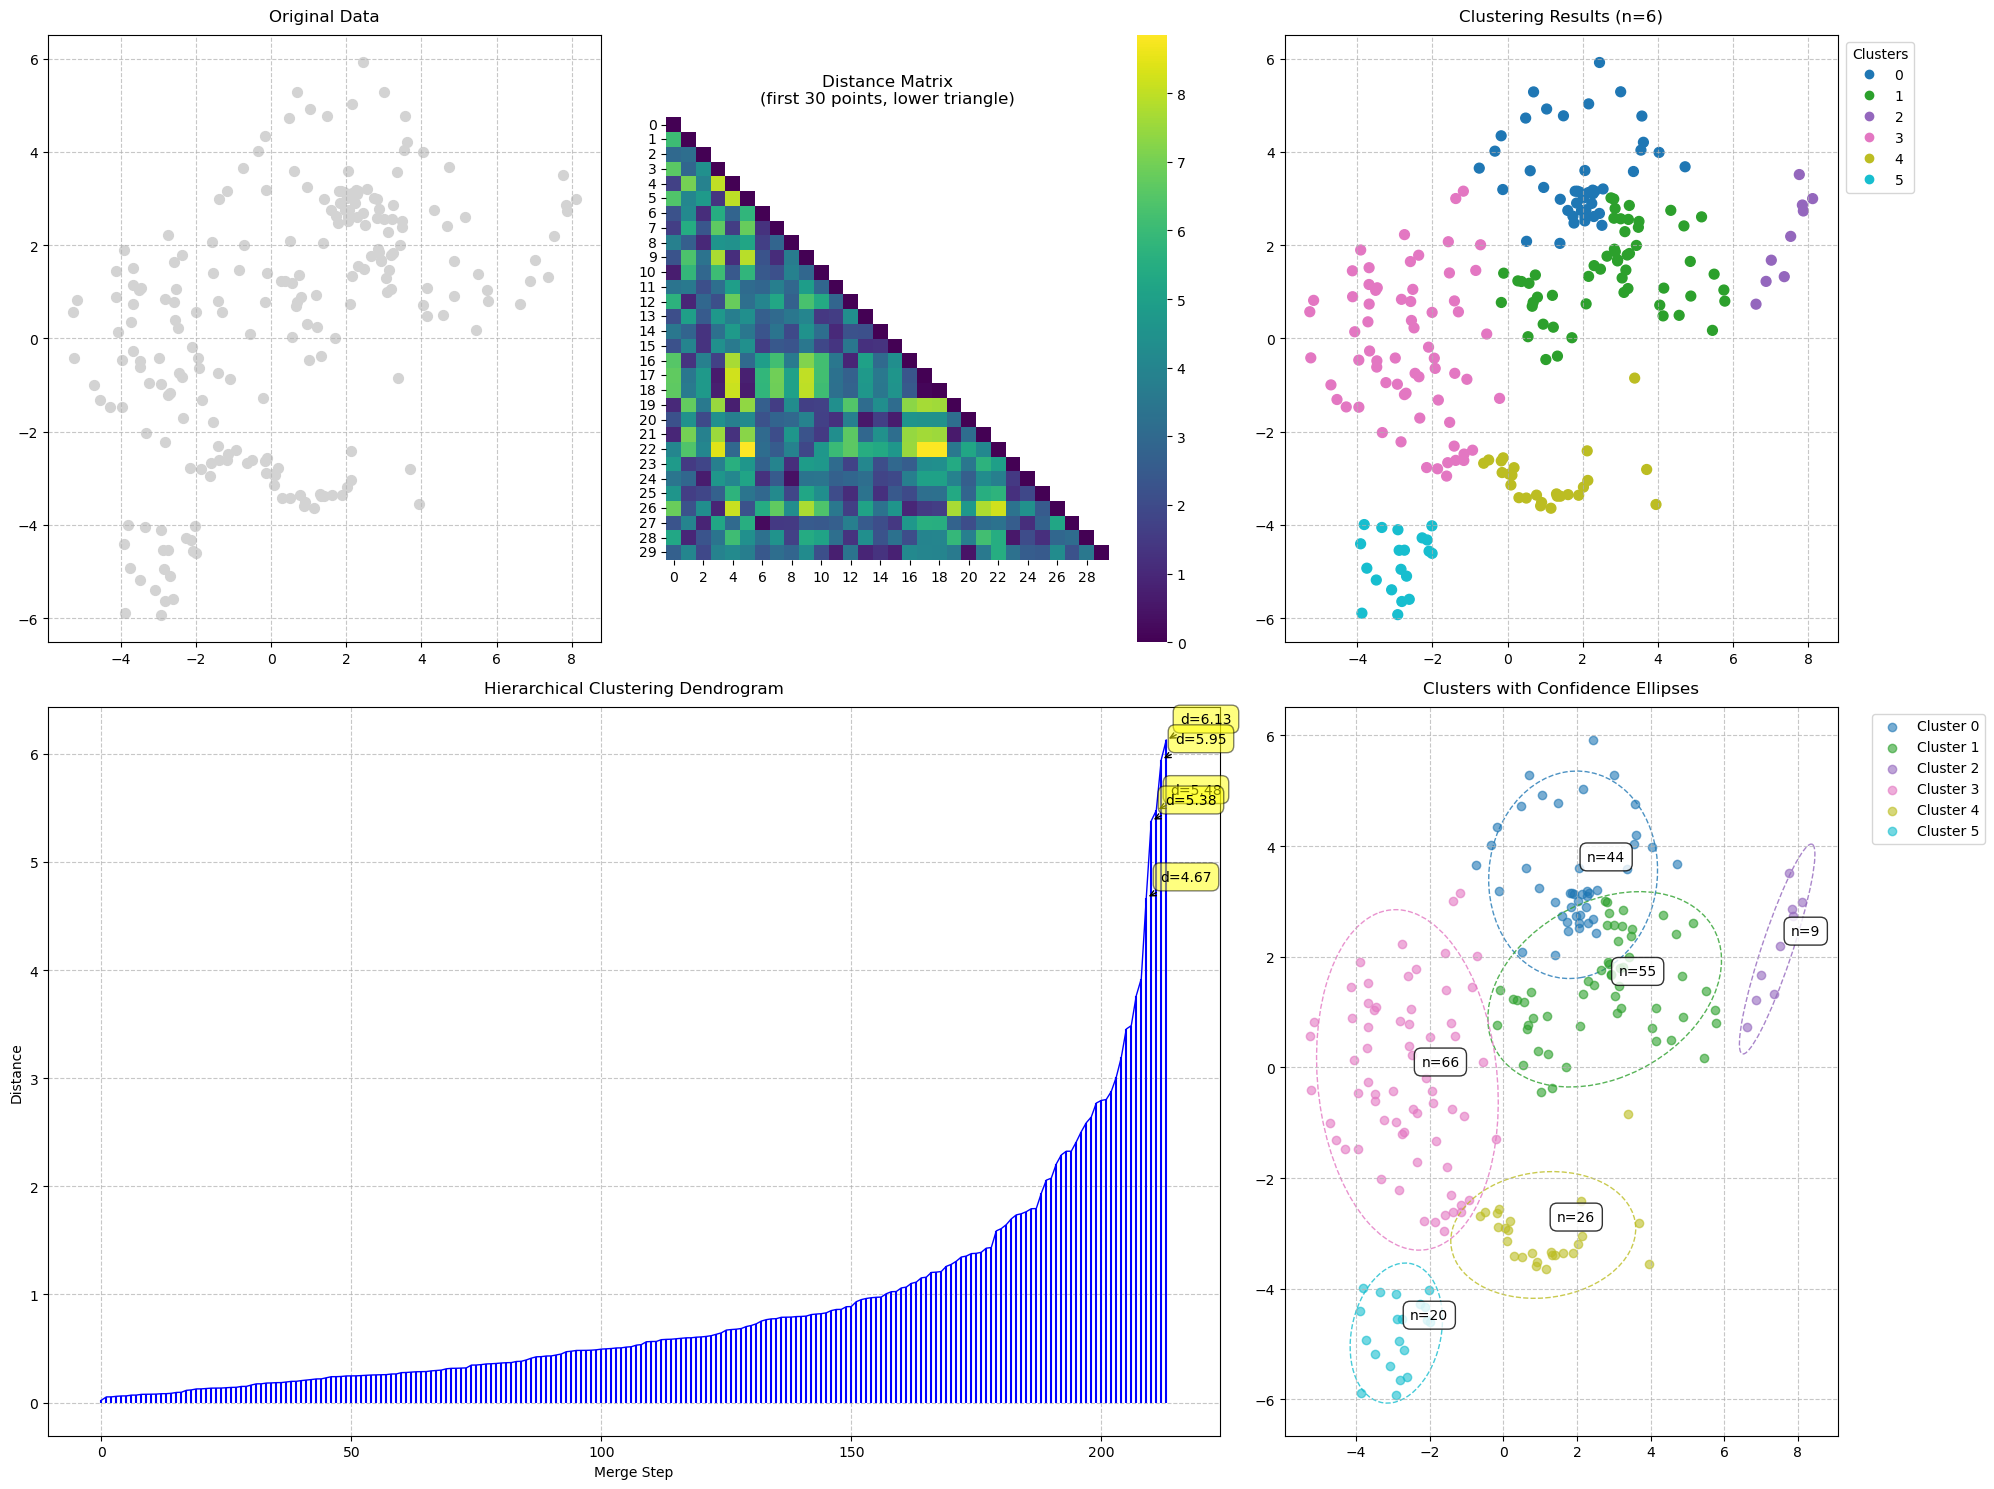


Clustering Statistics:

Cluster 0:
  Size: 44
  Center: (1.90, 3.48)
  Standard deviation: (1.13, 0.93)
  Average distance to center: 1.27
  Max distance to center: 2.83

Cluster 1:
  Size: 55
  Center: (2.75, 1.41)
  Standard deviation: (1.57, 0.87)
  Average distance to center: 1.59
  Max distance to center: 3.09

Cluster 2:
  Size: 9
  Center: (7.44, 2.14)
  Standard deviation: (0.48, 0.89)
  Average distance to center: 0.92
  Max distance to center: 1.63

Cluster 3:
  Size: 66
  Center: (-2.61, -0.23)
  Standard deviation: (1.23, 1.53)
  Average distance to center: 1.79
  Max distance to center: 3.67

Cluster 4:
  Size: 26
  Center: (1.08, -3.03)
  Standard deviation: (1.23, 0.56)
  Average distance to center: 1.14
  Max distance to center: 3.17

Cluster 5:
  Size: 20
  Center: (-2.91, -4.80)
  Standard deviation: (0.61, 0.62)
  Average distance to center: 0.80
  Max distance to center: 1.46


In [31]:
if __name__ == "__main__":
    X = generate_complex_dataset()
    
    hc = HierarchicalClustering(n_clusters=6, linkage='complete')
    labels = hc.fit_predict(X)
    
    fig = plot_clustering_results(X, hc)
    plt.show()
    
    print("\nClustering Statistics:")
    for i in range(hc.n_clusters):
        mask = labels == i
        cluster_points = X[mask]
        center = np.mean(cluster_points, axis=0)
        std_dev = np.std(cluster_points, axis=0)
        dist_to_center = np.sqrt(np.sum((cluster_points - center) ** 2, axis=1))
        
        print(f"\nCluster {i}:")
        print(f"  Size: {np.sum(mask)}")
        print(f"  Center: ({center[0]:.2f}, {center[1]:.2f})")
        print(f"  Standard deviation: ({std_dev[0]:.2f}, {std_dev[1]:.2f})")
        print(f"  Average distance to center: {np.mean(dist_to_center):.2f}")
        print(f"  Max distance to center: {np.max(dist_to_center):.2f}")